In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
from statsmodels.stats.multitest import multipletests

from scipy.stats import fisher_exact



pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%config InlineBackend.figure_format = "retina"

In [5]:
save = True     # whether or not to save elment to disk
user = 'general'     # defines top hierarchy of output folder
outfolder = '07_cluster_descriptions'    # name of notebook

data_to_load = 'general/05_join_clusters_umap/05_data_umap_clusters_220923_1402.csv.gz'

def dump_table(df, name):
    if save:
        export.full_frame(
            user, 
            f'{outfolder}/{name}', 
            df, 
            index=True,
            date=False
        )

def dump_figure(name):
    if save: 
        export.image(
            user,
            f'{outfolder}/{name}',
        )

In [6]:
data = pd.read_csv(
    inout.get_material_path(data_to_load), 
    index_col=0)

In [7]:
print(f"Total number of patients: {data.Patient_id.nunique()}")
print(f"Total number of ICU-days: {data.shape[0]}")

Total number of patients: 585
Total number of ICU-days: 12495


In [8]:

data.Discharge_disposition = data.Discharge_disposition.astype("category")

data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home',
    'Rehab', 
    'SNF',
    'LTACH',
    'Hospice',
    'Died'
])

DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [9]:
#rename to match old code 

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

# BALs per cluster

In [10]:
df = data.loc[data.has_bal, :].groupby(["cluster"]).count().day.reset_index()


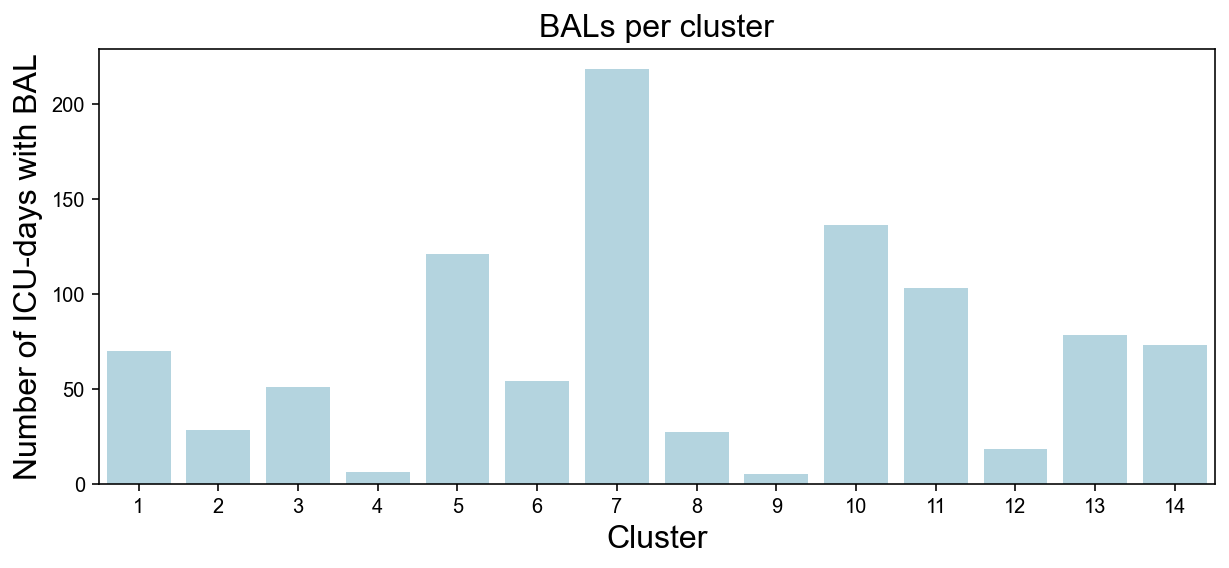

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    data=df, 
    x="cluster", 
    y="day", 
    color='lightblue'
)


ax.set_ylabel("Number of ICU-days with BAL", size=16)
ax.set_xlabel("Cluster", size=16)
ax.set_title("BALs per cluster", size=16)

dump_figure('BALs_per_cluster.pdf')

# First cluster per patient

In [12]:
first_days = data.groupby("patient").head(1).index

In [13]:
df = data.loc[first_days, :].groupby(["Discharge_disposition"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_1": "cluster"}, axis=1)


In [14]:
def plot(df):

    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    clustering.stacked_hue_barplot(
        df=df, 
        x="cluster", 
        y="count", 
        hue="Discharge_disposition", 
        stacks=DISCHARGE_STACKS,
        ax=ax,
        palette=mpl.colors.ListedColormap(DISCH_PALETTE),
    )
    ax.set_xlabel("Cluster", size=16)
    ax.set_ylabel("Number of patients", size=16)
    # ax.set_title("Distribution of first clusters for patients", size=16);
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlim(-1, 14 * 9 - 1)
    
    
    

def get_p_values(df):


    toy = df.copy()
    toy.loc[:, 'passed'] = toy['Discharge_disposition'].isin(['Hospice', 'Died'])
    total = toy.groupby('passed')['count'].sum()

    clusters = sorted(toy['cluster'].unique())
    res = pd.Series(index=clusters, data=False)
    for c in toy['cluster'].unique():
        d = toy[toy['cluster']==c]
        d = d.groupby(['passed'])['count'].sum()
        d = d.reindex([True, False]).fillna(0)

        a = d[True]
        b = d[False]
        a2 = total[True] - a
        b2 = total[False] - b
        _, pval = fisher_exact(
            ((a, b), (a2, b2))
        )
        res[c] = pval
    res = res.to_frame('fishers').rename_axis('cluster')
    res['benjamini_hochberg'] = multipletests(res['fishers'], method='fdr_bh')[1]

    return res    


,fishers,benjamini_hochberg
cluster,,
1,0.000677,0.004736
2,1.0,1.0
3,0.000191,0.002672
4,0.326473,0.415511
5,0.005988,0.027946
6,1.0,1.0
7,0.4329,0.50505
8,0.140219,0.280437
9,0.091614,0.213766


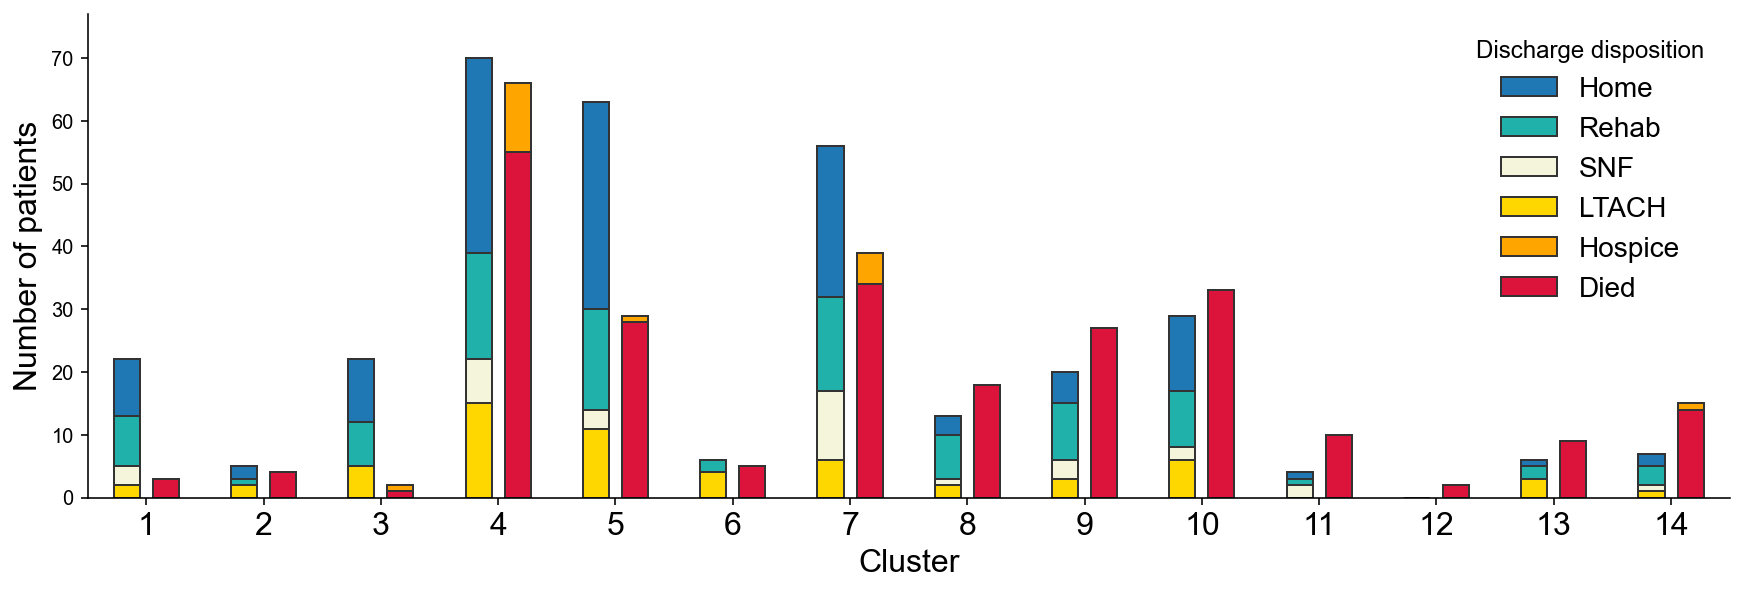

In [15]:
plot(df)  
dump_figure('first_cluster.pdf')

pvals = get_p_values(df)
dump_table(pvals, 'first.xlsx')
display(pvals)

# Last cluster for patient

In [16]:
last_days = data.groupby("patient").tail(1).index

In [17]:
df = data.loc[last_days, :].groupby(["Discharge_disposition"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_1": "cluster"}, axis=1)


,fishers,benjamini_hochberg
cluster,,
1,1.0,1.0
2,0.02215,0.03101
3,0.000017,0.000039
4,0.0,0.0
5,0.039724,0.050558
6,0.004022,0.007039
7,0.002873,0.005745
8,0.316344,0.355435
9,0.018147,0.028228


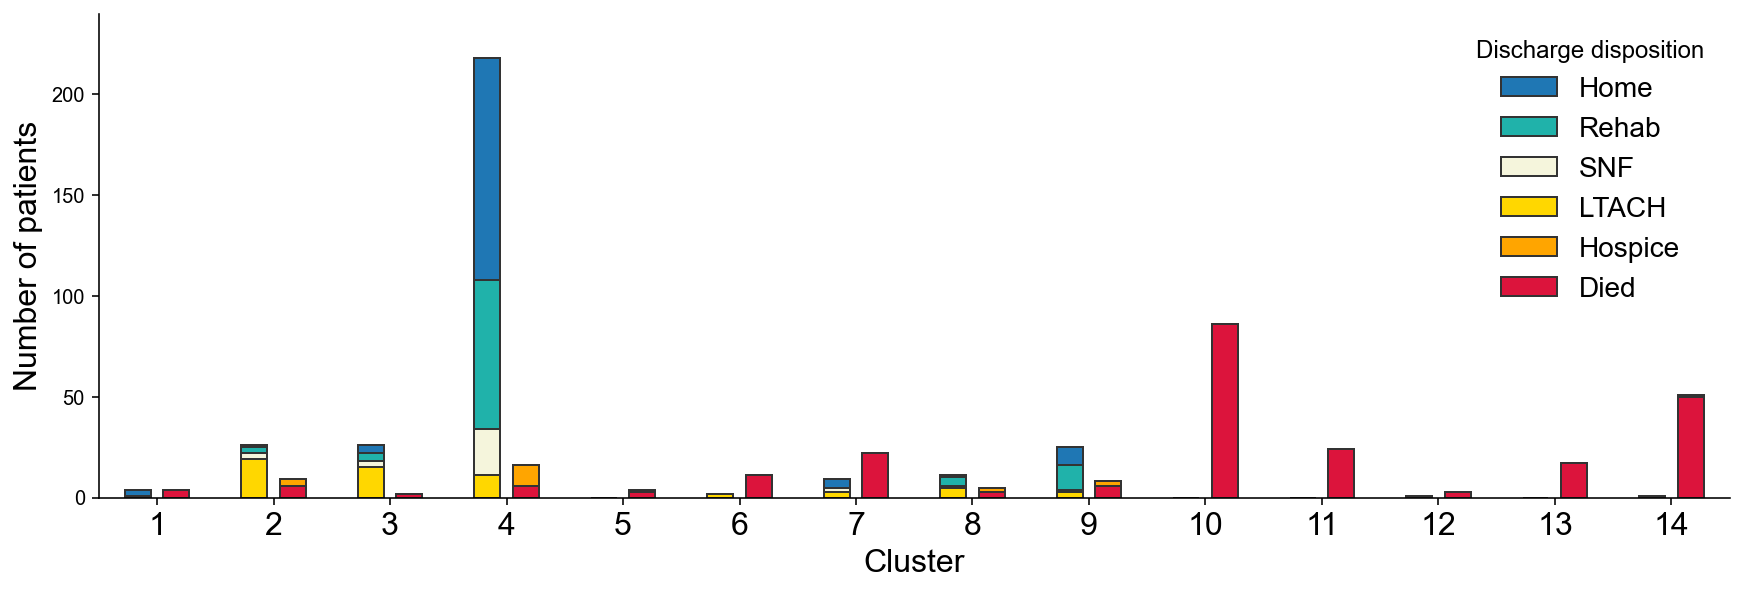

In [18]:
plot(df)  
dump_figure('last_cluster.pdf')

pvals = get_p_values(df)
dump_table(pvals, 'last_cluster.xlsx')
display(pvals)

In [19]:
for j in pvals.index:
    print(j, pvals.loc[j, 'benjamini_hochberg'])

1 1.0
2 0.031010144865821397
3 3.9406011359632393e-05
4 9.841710483491444e-57
5 0.05055801432620222
6 0.0070390978303983415
7 0.005745152244699433
8 0.355435302946673
9 0.028228248470437953
10 7.040560825569653e-34
11 8.080318492139906e-09
12 0.355435302946673
13 2.444752048271722e-06
14 1.2344051440753998e-17


Compute stats for each cluster parameter

In [20]:
PARAMETRIC_TEST_CUTOFF = 8

In [21]:
NA_PERCENTAGE_CUTOFF = 0.8

In [24]:
cluster_counts = data.cluster.value_counts().sort_index()

In [25]:
result = []
for c in clustering.get_reference_data_columns():
    is_parametric = data[c].nunique() > PARAMETRIC_TEST_CUTOFF
    clusters = cluster_counts.copy()
    cluster_nas = data.groupby("cluster")[c].apply(lambda x: x.isna().sum()) / cluster_counts
    na_clusters = cluster_nas.index[cluster_nas > NA_PERCENTAGE_CUTOFF]
    clusters[na_clusters] = np.nan
    remaining_clusters = clusters[~clusters.isna()].copy()
    c_means = data.groupby("cluster")[c].mean()
    remaining_clusters = c_means[remaining_clusters.index].sort_values()
#     print(remaining_clusters)
    breaks = [0]
    for i in range(remaining_clusters.size - 1):
        g1 = remaining_clusters.index[i]
        g2 = remaining_clusters.index[i + 1]
        f1 = data[c][data.cluster == g1].dropna()
        f2 = data[c][data.cluster == g2].dropna()
        if is_parametric:
            pval = scipy.stats.ttest_ind(f1, f2).pvalue
        else:
            pval = scipy.stats.mannwhitneyu(f1, f2).pvalue
#         print(i, pval)
        if pval < 0.05:
            breaks.append(i + 1)
    breaks.append(remaining_clusters.size)
#     print(breaks)
    for i in range(1, len(breaks) - 1):
        g1_start = breaks[i - 1]
        g1_end = breaks[i]
        g2_end = breaks[i + 1]
        g1 = remaining_clusters.index[g1_start:g1_end]
        g2 = remaining_clusters.index[g1_end:g2_end]
        f1 = data[c][data.cluster.isin(g1)].dropna()
        f2 = data[c][data.cluster.isin(g2)].dropna()
        if is_parametric:
            pval = scipy.stats.ttest_ind(f1, f2).pvalue
        else:
            pval = scipy.stats.mannwhitneyu(f1, f2).pvalue
        result.append([c, i, "+".join(g1.astype(str)), "+".join(g2.astype(str)), 
                       f1.mean(), f2.mean(), f1.std(), f2.std(), pval])
#     break
result = pd.DataFrame(result, columns=["measurement", "break_num", "group1", "group2", 
                                       "g1mean", "g2mean", "g1std", "g2std", "pval"])


In [26]:
result["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(result.pval, alpha=0.05)[1]

In [29]:
markers_data = pd.DataFrame(index=cluster_counts.index, columns=clustering.get_reference_data_columns())
cluster_comp = pd.DataFrame("", index=cluster_counts.index, columns=cluster_counts.index)
for c in clustering.get_reference_data_columns():
    breaks = result.loc[result.measurement == c, :]
    clusters = {}
    for _, b in breaks.iterrows():
        for cluster in b.group1.split("+"):
            if cluster not in clusters:
                clusters[cluster] = {}
            clusters[cluster]["<"] = "*" if b.pval_adj < 0.01 else "ns"
            clusters[cluster]["rank"] = f"{b.break_num}/{breaks.shape[0] + 1}"
            clusters[cluster]["val"] = f"{b.g1mean:.2f}±{b.g1std:.2f}"
        for cluster in b.group2.split("+"):
            if cluster not in clusters:
                clusters[cluster] = {}
            clusters[cluster][">"] = "*" if b.pval_adj < 0.01 else "ns"
            clusters[cluster]["rank"] = f"{b.break_num + 1}/{breaks.shape[0] + 1}"
            clusters[cluster]["val"] = f"{b.g2mean:.2f}±{b.g2std:.2f}"
    for k, i in clusters.items():
        c_str = i["rank"] + " " + i["val"] + f" ("
        if ">" in i:
            c_str += i[">"] + "<"
        c_str += "x"
        if "<" in i:
            c_str += "<" + i["<"]
        c_str += ")"
        markers_data.loc[int(k), c] = c_str
    for k, i in clusters.items():
        k = int(k)
        for l, j in clusters.items():
            l = int(l)
            if k >= l:
                continue
            c_str = ""
            i_r = int(i["rank"].split("/")[0])
            j_r = int(j["rank"].split("/")[0])
            if j_r - i_r > 2 and i.get("<", "*") == "*" and j.get(">", "*") == "*":
                c_str += f"<{c} "
            if i_r - j_r > 2 and i.get(">", "*") == "*" and j.get("<", "*") == "*":
                c_str += f">{c} "
            cluster_comp.loc[k, l] += c_str

In [33]:
dump_table(markers_data.fillna(">80% NA").T, "cluster_markers.csv")

Ridge plots

In [58]:
icu_rank_lengths = data.groupby(["patient", "stay"]).agg({"day": "max"})

In [60]:
df = data[["cluster", "stay", "day", "patient"]].copy()

In [61]:
df.day /= icu_rank_lengths.day[pd.MultiIndex.from_arrays([data.patient, data.stay])].values

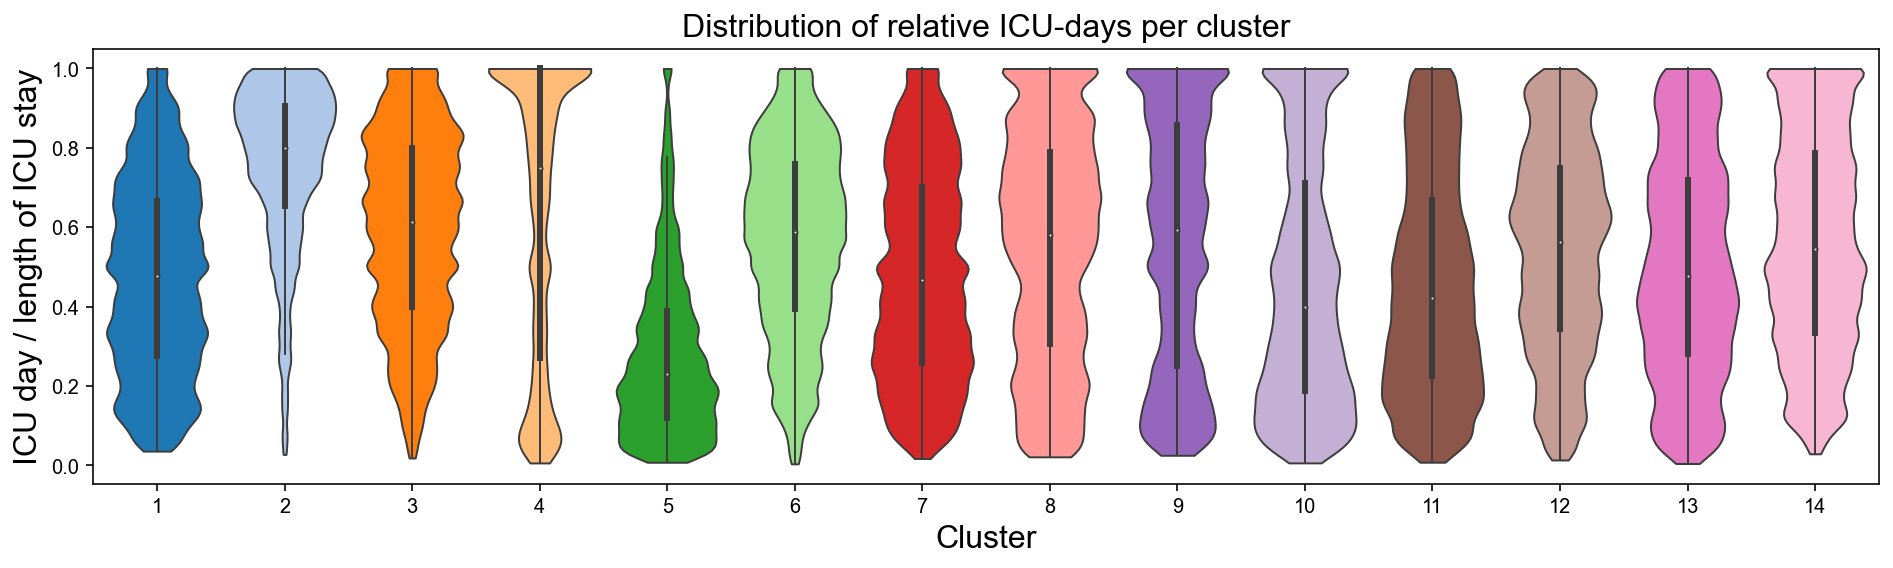

In [62]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(
    data=df, 
    x="cluster", 
    y="day", 
    ax=ax,
    palette="tab20",
    saturation=1,
    linewidth=1,
    cut=0,
    bw=0.1,
    scale="width"
)
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("ICU day / length of ICU stay", size=16)
ax.set_title("Distribution of relative ICU-days per cluster", size=16);

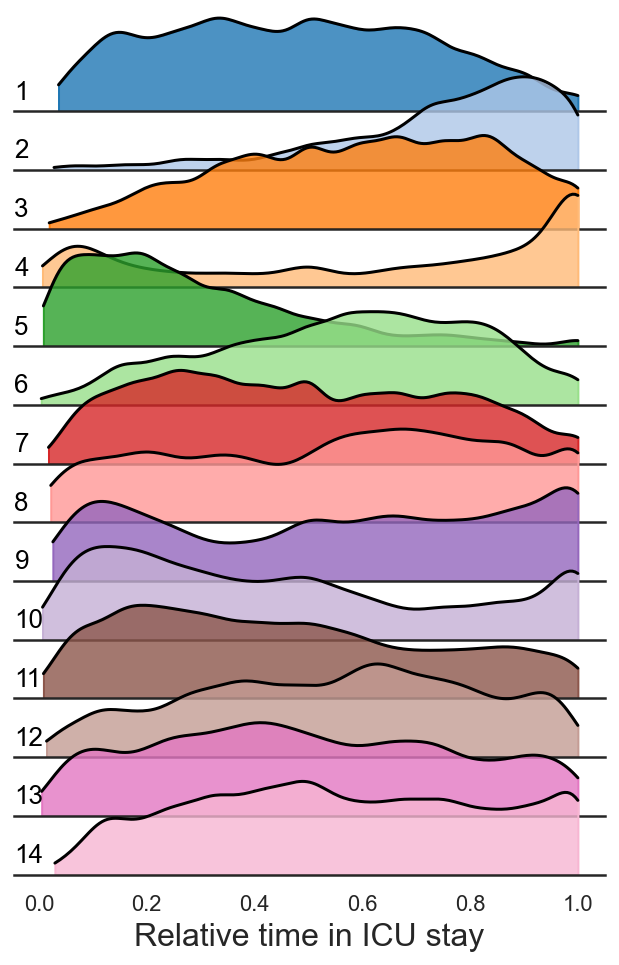

In [106]:
sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0)}, style="white")

g = sns.FacetGrid(
    df, 
    row="cluster", 
    hue="cluster",
    palette=mpl.cm.tab20.colors,
    aspect=10, 
    height=0.5,
    sharey=False
)

g.map_dataframe(sns.kdeplot, x="day", fill=True, alpha=0.8, cut=0, bw_adjust=0.5)
g.map_dataframe(sns.kdeplot, x="day", color="black", alpha=1, cut=0, bw_adjust=0.5)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "cluster")

g.fig.subplots_adjust(hspace=-0.4)

g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Relative time in ICU stay")
g.despine(left=True)
g.axes[-1, 0].set_xlabel("Relative time in ICU stay", size=16)
dump_figure("ridge.pdf")